## Neural Machine Translation with Attention
https://github.com/tensorflow/tensorflow/blob/r1.11/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb
This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation using tf.keras and eager execution. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a Spanish sentence, such as "¿todavia estan en casa?", and return the English translation: "are you still at home?"

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

In [116]:
import tensorflow as tf

# tf.enable_eager_execution()

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

### Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

May I borrow this book?    ¿Puedo tomar prestado este libro?

There are a variety of languages available, but we'll use the English-Spanish dataset. For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

- Add a start and end token to each sentence.
- Clean the sentences by removing special characters.
- Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
- Pad each sentence to a maximum length.

In [4]:
path_to_zip = tf.keras.utils.get_file(
    '/data/tmp/spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip', 
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return word_pairs

# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split(' '))
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word
    
def max_length(tensor):
    return max(len(t) for t in tensor)

def load_dataset(path, num_examples):
    # creating cleaned input, output pairs
    pairs = create_dataset(path, num_examples)

    # index language using the class defined above    
    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)
    
    # Vectorize the input and target languages
    
    # Spanish sentences
    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]
    
    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

2646016/2638744 [==============================] - 0s 0us/step


### Optional: limit the size of the dataset

In [98]:
# Try experimenting with the size of that dataset
num_examples = 15000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)


(8000, 8000, 2000, 2000)

Print some examples

In [99]:
example_idx = np.random.randint(len(input_tensor_train))
spanish = ' '.join([inp_lang.idx2word[w] for w in input_tensor_train[example_idx]])
english = ' '.join([targ_lang.idx2word[w] for w in target_tensor_train[example_idx]])
print('Spanish:', spanish)
print('English:', english)

Spanish: <start> tom es un perdedor . <end> <pad> <pad> <pad> <pad> <pad>
English: <start> tom is a loser . <end> <pad>


### Create a tf.data dataset

In [106]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

## Overwrite parameters due to memory issues

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 1
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 128
units = 48
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)


dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

### Create model

We're using Bahdanau attention. Lets decide on notation before writing the simplified form:

- FC = Fully connected (dense) layer
- EO = Encoder output
- H = hidden state
- X = input to the decoder

And the pseudo-code:

- score = FC(tanh(FC(EO) + FC(H)))
- attention weights = softmax(score, axis = 1). Softmax by default is applied on the last axis but here we want to apply it on the 1st axis, since the shape of score is (batch_size, max_length, hidden_size). Max_length is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
- context vector = sum(attention weights * EO, axis = 1). Same reason as above for choosing axis as 1.
- embedding output = The input to the decoder X is passed through an embedding layer.
- merged vector = concat(embedding output, context vector)
This merged vector is then given to the GRU


In [107]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, hidden_size)
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [108]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [109]:


optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)



In [110]:
checkpoint_dir = '/data/tmp/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training

1. Pass the input through the encoder which return encoder output and the encoder hidden state.
2. The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
3. The decoder returns the predictions and the decoder hidden state.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use teacher forcing to decide the next input to the decoder.
6. Teacher forcing is the technique where the target word is passed as the next input to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [113]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9897
Epoch 1 Batch 100 Loss 1.3335
Epoch 1 Batch 200 Loss 0.8904
Epoch 1 Batch 300 Loss 0.8897
Epoch 1 Batch 400 Loss 1.1279
Epoch 1 Batch 500 Loss 1.7093
Epoch 1 Batch 600 Loss 1.6678
Epoch 1 Batch 700 Loss 1.1833
Epoch 1 Batch 800 Loss 0.9125
Epoch 1 Batch 900 Loss 0.9556
Epoch 1 Batch 1000 Loss 1.1936
Epoch 1 Batch 1100 Loss 1.2137
Epoch 1 Batch 1200 Loss 1.3539
Epoch 1 Batch 1300 Loss 0.9158
Epoch 1 Batch 1400 Loss 1.1657
Epoch 1 Batch 1500 Loss 1.4911
Epoch 1 Batch 1600 Loss 0.6723
Epoch 1 Batch 1700 Loss 1.1018
Epoch 1 Batch 1800 Loss 1.0640
Epoch 1 Batch 1900 Loss 1.8484
Epoch 1 Batch 2000 Loss 1.4142
Epoch 1 Batch 2100 Loss 0.8755
Epoch 1 Batch 2200 Loss 1.3420
Epoch 1 Batch 2300 Loss 0.9211
Epoch 1 Batch 2400 Loss 1.1922
Epoch 1 Batch 2500 Loss 1.0782
Epoch 1 Batch 2600 Loss 0.7846
Epoch 1 Batch 2700 Loss 1.0941
Epoch 1 Batch 2800 Loss 1.2993
Epoch 1 Batch 2900 Loss 1.3532
Epoch 1 Batch 3000 Loss 2.5322
Epoch 1 Batch 3100 Loss 0.6309
Epoch 1 Batch 3200 L

Epoch 4 Batch 2000 Loss 1.1007
Epoch 4 Batch 2100 Loss 0.8987
Epoch 4 Batch 2200 Loss 1.6108
Epoch 4 Batch 2300 Loss 0.7839
Epoch 4 Batch 2400 Loss 2.0212
Epoch 4 Batch 2500 Loss 1.3703
Epoch 4 Batch 2600 Loss 1.1384
Epoch 4 Batch 2700 Loss 0.1477
Epoch 4 Batch 2800 Loss 0.7981
Epoch 4 Batch 2900 Loss 0.8430
Epoch 4 Batch 3000 Loss 0.6251
Epoch 4 Batch 3100 Loss 1.1086
Epoch 4 Batch 3200 Loss 0.9761
Epoch 4 Batch 3300 Loss 1.0589
Epoch 4 Batch 3400 Loss 0.6988
Epoch 4 Batch 3500 Loss 1.1598
Epoch 4 Batch 3600 Loss 2.4260
Epoch 4 Batch 3700 Loss 0.9166
Epoch 4 Batch 3800 Loss 1.0400
Epoch 4 Batch 3900 Loss 1.4385
Epoch 4 Batch 4000 Loss 1.3419
Epoch 4 Batch 4100 Loss 0.6452
Epoch 4 Batch 4200 Loss 0.5672
Epoch 4 Batch 4300 Loss 1.0752
Epoch 4 Batch 4400 Loss 0.8034
Epoch 4 Batch 4500 Loss 0.7713
Epoch 4 Batch 4600 Loss 1.8893
Epoch 4 Batch 4700 Loss 1.9108
Epoch 4 Batch 4800 Loss 1.5869
Epoch 4 Batch 4900 Loss 0.8629
Epoch 4 Batch 5000 Loss 1.0742
Epoch 4 Batch 5100 Loss 1.6411
Epoch 4 

Epoch 7 Batch 4000 Loss 0.9591
Epoch 7 Batch 4100 Loss 2.0651
Epoch 7 Batch 4200 Loss 1.4897
Epoch 7 Batch 4300 Loss 0.8756
Epoch 7 Batch 4400 Loss 0.6262
Epoch 7 Batch 4500 Loss 1.3207
Epoch 7 Batch 4600 Loss 0.9601
Epoch 7 Batch 4700 Loss 0.5284
Epoch 7 Batch 4800 Loss 0.7575
Epoch 7 Batch 4900 Loss 0.6236
Epoch 7 Batch 5000 Loss 1.4375
Epoch 7 Batch 5100 Loss 0.9809
Epoch 7 Batch 5200 Loss 1.8400
Epoch 7 Batch 5300 Loss 0.7477
Epoch 7 Batch 5400 Loss 0.7776
Epoch 7 Batch 5500 Loss 0.5338
Epoch 7 Batch 5600 Loss 0.6591
Epoch 7 Batch 5700 Loss 0.4577
Epoch 7 Batch 5800 Loss 0.6964
Epoch 7 Batch 5900 Loss 0.9755
Epoch 7 Batch 6000 Loss 1.1197
Epoch 7 Batch 6100 Loss 0.3528
Epoch 7 Batch 6200 Loss 0.2153
Epoch 7 Batch 6300 Loss 1.3685
Epoch 7 Batch 6400 Loss 1.0135
Epoch 7 Batch 6500 Loss 0.9165
Epoch 7 Batch 6600 Loss 0.8203
Epoch 7 Batch 6700 Loss 0.5820
Epoch 7 Batch 6800 Loss 0.6745
Epoch 7 Batch 6900 Loss 1.3733
Epoch 7 Batch 7000 Loss 0.6783
Epoch 7 Batch 7100 Loss 2.5899
Epoch 7 

Epoch 10 Batch 5800 Loss 0.5067
Epoch 10 Batch 5900 Loss 0.5061
Epoch 10 Batch 6000 Loss 0.7088
Epoch 10 Batch 6100 Loss 0.7320
Epoch 10 Batch 6200 Loss 0.4180
Epoch 10 Batch 6300 Loss 0.9419
Epoch 10 Batch 6400 Loss 0.3827
Epoch 10 Batch 6500 Loss 0.6148
Epoch 10 Batch 6600 Loss 0.6951
Epoch 10 Batch 6700 Loss 0.8594
Epoch 10 Batch 6800 Loss 1.4661
Epoch 10 Batch 6900 Loss 0.8018
Epoch 10 Batch 7000 Loss 0.3941
Epoch 10 Batch 7100 Loss 1.5144
Epoch 10 Batch 7200 Loss 1.2956
Epoch 10 Batch 7300 Loss 1.2861
Epoch 10 Batch 7400 Loss 0.9262
Epoch 10 Batch 7500 Loss 0.3403
Epoch 10 Batch 7600 Loss 1.3345
Epoch 10 Batch 7700 Loss 0.5240
Epoch 10 Batch 7800 Loss 0.5863
Epoch 10 Batch 7900 Loss 0.2477
Epoch 10 Loss 0.7698
Time taken for 1 epoch 747.1710212230682 sec




### Translate

The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
Stop predicting when the model predicts the end token.
And store the attention weights for every time step.

Note: The encoder output is calculated only once for one input.


In [117]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.multinomial(predictions, num_samples=1)[0][0].numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()
    
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: that s alive . <end> 


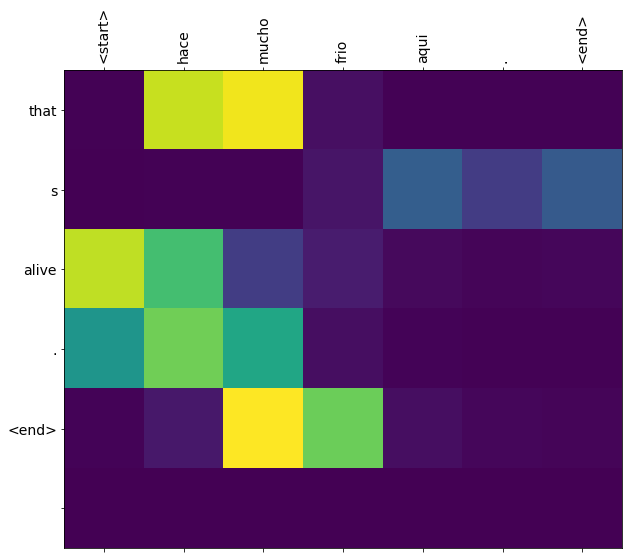

In [120]:
translate('hace mucho frio aqui.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> hoy es miercoles <end>
Predicted translation: this is life . <end> 


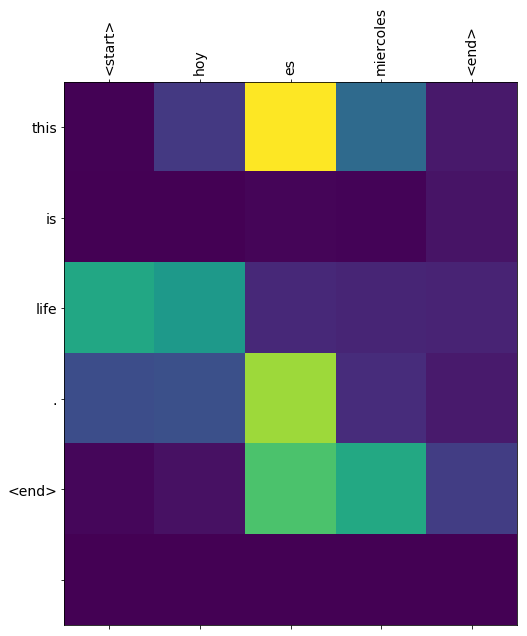

In [132]:
translate('hoy es miercoles', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)